In [48]:
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.types import StructType
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf
import pandas as pd
import os 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns


In [5]:
airports=pd.read_csv('DATASETS/aeropuertos.csv')
flights=pd.read_csv('DATASETS/vuelos.csv')
coverage=pd.read_csv('DATASETS/Cobertura de Aerea de Centros Poblados por Categoria de Aeropuerto1.csv')
distance_matrix=pd.read_csv('DATASETS/Matriz de distancias entre aeropuertos y centros poblados de Colombia1.csv')

In [15]:
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars /usr/share/java/mariadb-java-client-2.5.3.jar pyspark-shell'

In [6]:
airports.head(5)

,Unnamed: 0,sigla,iata,nombre,municipio,departamento,categoria,latitud,longitud,propietario,...,pbmo,elevacion,resolucion,fecha_construccion,fecha_vigencia,clase,tipo,numero_vuelos_origen,gcd_departamento,gcd_municipio
0,274,BOG,BOG,EL DORADO,"Bogotá, D.C.","Bogotá, D.C.",Internacional,4.7017,-74.1469,AEROCIVIL,...,NaN,8356.0,"320,000",1999-12-09,NaN,4E,Aerocivil,1804153.0,11,11001
1,134,9DG,NaN,EL LAGO - CA,Piedras,Tolima,Aeródromo,4.5575,-74.9003,BERNEY RODRIGUEZ,...,500.0,1050.0,"6744,000",2016-12-17,NaN,UL,Privado,479797.0,73,73547
2,803,TLU,TLU,TOLU,Tolú Viejo,Sucre,Regional,9.5095,-75.5859,AEROCIVIL,...,12202.0,15.0,"455,000",2000-12-24,NaN,2A,Aerocivil,227253.0,70,70823
3,174,9MK,NaN,VILLA ISABELLA,Trinidad,Casanare,Aeródromo,5.2993,-71.3434,RAFAEL QUESADA,...,2000.0,620.0,"4313,000",2018-10-31,NaN,1A,Fumigación,493950.0,85,85430
4,344,CUC,CUC,CAMILO DAZA,San José de Cúcuta,Norte de Santander,Internacional,7.9274,-72.5116,AEROCIVIL,...,NaN,1027.0,"984,000",2013-04-28,NaN,4D,Aerocivil,91797.0,54,54001


In [7]:
flights.head(5)

,ano,mes,origen,destino,tipo_equipo,tipo_vuelo,trafico,empresa,vuelos,sillas,carga_ofrecida,pasajeros,carga_bordo
0,2012,1,BOG,CUC,BE20,T,N,RIO SUR,1.0,0.0,0.0,4.0,100.00
1,2013,5,UIB,BOG,DH8D,R,N,AIRES,30.0,1110.0,24000.0,873.0,4222.00
2,2013,10,IBE,BOG,DH8D,R,N,AIRES,98.0,3626.0,56056.0,2866.0,2323.75
3,2012,4,FLA,BOG,JS32,T,N,SARPA S.A.S,1.0,0.0,0.0,4.0,0.00
4,2013,7,CUC,AUC,C402,T,N,AEROCHARTER ANDINA S.A.S.,1.0,0.0,0.0,NaN,180.00


In [8]:
coverage.head(5)

,Centro Poblado,Aeropuerto,Distancia(Km),Cobertura,Aerodromo,D_Aerodromo,Regional,D_Regional,Nacional,D_Nacional,Internacional,D_Internacional,Tipo_Cobertura
0,ABASTICOS,EL DORADO,34.449084,True,VILLA GEORGINA,36.210661,SAN MARTIN,87.851597,VANGUARDIA,51.688342,EL DORADO,34.449084,Internacional
1,ACAPULCO,HORIZONTES,3.304030,True,HORIZONTES,3.304030,COLONIZADORES,141.025013,YARIGUIES,74.430417,PALONEGRO,14.211116,Internacional
2,ACEVEDO,CONTADOR,22.653257,True,LA JAGUA,43.649363,CONTADOR,22.653257,GUSTAVO ARTUNDUAGA PAREDES,43.323740,BENITO SALAS,143.390690,Regional
3,BARRO BLANCO,SAN BERNARDO,25.369714,True,SAN BERNARDO,25.369714,LAS BRUJAS,71.822006,LOS GARZONES,144.989267,RAFAEL NUÑEZ,152.243582,Aeródromo
4,EL CERRO,ANTONIO NARIÑO,38.078143,True,EL GUAYABAL,71.301646,JUAN CASIANO,109.195513,ANTONIO NARIÑO,38.078143,ALFONSO BONILLA ARAGON,240.676995,Nacional


In [10]:
distance_matrix.head(5)

,Unnamed: 0,LA ESCONDIDA,MORICHITO,CAROLINA DEL PRINCIPE,DUBAI,BARU - HIDROPUERTO,LA CAROLINA,SAN FELIPE DEL PAUTO,VELASQUEZ,LA UNION,...,EL CARAÑO,ALI PIEDRAHITA,CANANGUCHAL,ALFONSO LOPEZ PUMAREJO,VANGUARDIA,SANTA ISABEL,YAPIMA,TROMPILLOS,GERMAN ALBERTO,GUILLERMO GOMEZ ORTIZ
0,MEDELLÍN,518.684260,420.474206,62.115834,235.835111,443.155020,NaN,531.343868,NaN,411.402826,...,132.476374,62.450942,596.725928,531.707598,317.562827,363.536419,886.663930,397.576736,379.704439,260.301322
1,PALMITAS,533.674256,433.406864,61.183427,228.978014,432.556824,NaN,545.397309,NaN,427.255611,...,127.780610,49.859213,605.141477,528.260853,333.598283,379.616430,902.742961,412.404487,394.453735,269.874289
2,SANTA ELENA,568.950644,552.693836,357.166564,533.140918,735.046262,NaN,616.344711,NaN,328.016675,...,231.096638,297.572907,300.242496,822.819898,296.053584,337.536085,801.592315,476.955119,466.238730,475.929363
3,ALTAVISTA,522.647932,425.427065,67.106292,239.737678,445.797572,NaN,535.852651,NaN,412.576865,...,126.674038,57.800802,593.181819,536.502017,319.265142,365.519843,888.950776,401.666360,383.847916,265.939092
4,AGUAS FRÍAS,523.704731,426.247639,66.649328,238.925792,444.747666,NaN,536.797939,NaN,413.865677,...,126.518501,56.869188,594.086569,535.937972,320.539695,366.782340,890.197366,402.699649,384.870824,266.419993


In [69]:
# Estacio para funciones

# Funcion para explorar las caracteristicas de los DataFrames
def describe_exploration(df):
    
    s=df.shape
    t=df.dtypes
    d=df.describe()
    d_o=df.describe(include='object')
    
    return s, t, d, d_o

#Exploracion de la informacion de las columnas
def columns_exploration(df,column_name):
    print(df[column_name].value_counts())
    

# Funcion para explorar de los valores nulos
def null_exploration(df):
    
    print(df.isnull().sum())
    print(df.isnull().mean())

# Cambio de los valores nulos
def null_imputation(df,column_name):
    df[column_name].fillna(df[column_name].mean(), inplace=True)
    
    return df

def hist_graph(df, column_names):
    for column_name in column_names:

        df[column_name].hist(bins=30, figsize=(15,7), density=True, histtype='step',linewidth=2)
        plt.xticks(rotation='vertical')

        plt.title(column_name)
        plt.show()


def hori_boxplot(x,y, data):
    sns.set_theme(style="ticks")

    # Initialize the figure with a logarithmic x axis
    f, ax = plt.subplots(figsize=(10,20))
    ax.set_xscale("log")

    # dataset
    data

    # Plot the orbital period with horizontal boxes
    sns.boxplot(x=x, y=y, data=data,
                whis=[0, 100], width=.4, orient="h",palette="Set3")

    # Add in points to show each observation
    sns.stripplot(x=x, y=y, data=data,
                  size=3, color=".3", linewidth=0)

    # Tweak the visual presentation
    ax.xaxis.grid(True)
    ax.set(ylabel="")
    sns.despine(trim=True, left=True)
    return plt.show()

def groupby_2_cols_against_target(df, column1, column2, target):

    groupby_2_cols_against_target = df.groupby(
        [column1, column2]
    )[target].sum() / df.groupby(
        [column1, column2]
    )[target].count() * 100.0

    pivot_t = groupby_2_cols_against_target.reset_index().pivot(
        index=column1,
        columns=column2,
        values=target
    )
    
    return pivot_t


def groupby_var_target(df, column_name, target_name, title):
    ## group by
    groupby_var_target = df.groupby(
        column_name
    )[target_name].sum() / df.groupby(
        column_name
    )[target_name].count() * 100.0
    
    ## plot groupby
    ax = groupby_var_target.sort_values(ascending=False).plot(
        kind='bar',
        color='skyblue',
        grid=True,
        figsize=(10, 7),
        title=title
    )

def groupby_var_percent(df, column_name, target_name, title):
    ## group by
    groupby_var_target = df.groupby(
        column_name
    )[target_name].sum() / df.groupby(
        column_name
    )[target_name].count() 
    
    ## plot groupby
    ax = groupby_var_target.sort_values(ascending=False).plot(
        kind='bar',
        color='skyblue',
        grid=True,
        figsize=(10, 7),
        title=title
    )
    
    return groupby_var_target, plt.show()



In [12]:
# Exploracion de la informacion de los DataFrames disponibles
list_df=[flights, airports, coverage]
for i in list_df:
    s, t, d, d_o=describe_exploration(i)
    print(f'A continuacion los datos del DataSet La dimension es: {s}')
    print(f'El tipo de datos: {t}')
    print(f'El resumen de la informacion estadistica de valores numericos: {d}')
    print(f'El resumen de la informacion estadistica tipo str: {d_o}')

A continuacion los datos del DataSet La dimension es: (67599, 13)
El tipo de datos: ano                 int64
mes                 int64
origen             object
destino            object
tipo_equipo        object
tipo_vuelo         object
trafico            object
empresa            object
vuelos            float64
sillas            float64
carga_ofrecida    float64
pasajeros         float64
carga_bordo       float64
dtype: object
El resumen de la informacion estadistica de valores numericos:                 ano           mes        vuelos        sillas  carga_ofrecida  \
count  67599.000000  67599.000000  66017.000000  63582.000000    6.759900e+04   
mean    2011.592864      6.674359     14.263735   1133.122535    4.675849e+04   
std        1.116215      3.442955     40.198515   4468.301902    2.306673e+05   
min     2010.000000      1.000000      1.000000      0.000000    0.000000e+00   
25%     2011.000000      4.000000      1.000000      0.000000    0.000000e+00   
50%     2012.00

In [13]:
# Evaluando las columnas de cada Dataset 
for j in list_df:
    for i in j:
        columns_exploration(j,i)

2013    18933
2012    17231
2011    16415
2010    15020
Name: ano, dtype: int64
12    6420
10    6077
6     5919
8     5787
7     5609
5     5566
11    5561
9     5548
3     5546
4     5298
2     5266
1     5002
Name: mes, dtype: int64
BOG    18257
VVC     5433
CLO     4037
EYP     3927
NVA     2641
       ...  
AGB        1
9MW        1
9CZ        1
9CI        1
9CR        1
Name: origen, Length: 111, dtype: int64
BOG    18161
VVC     5260
EYP     4019
CLO     3981
NVA     2537
       ...  
9CL        1
EJU        1
AFI        1
ATC        1
9CR        1
Name: destino, Length: 110, dtype: int64
B190    6262
PA34    5808
C206    3492
BE20    2624
D328    2612
        ... 
PA36       1
AT4        1
B742       1
B743       1
P28B       1
Name: tipo_equipo, Length: 94, dtype: int64
T    41371
R    24092
A     1531
C      605
Name: tipo_vuelo, dtype: int64
N    66705
Name: trafico, dtype: int64
SEARCA S.A.                                       8522
AVIANCA                                  

In [14]:
#Verificando los valores nulos y su cantidad
for j in list_df:
    null_exploration(j)    

ano                  0
mes                  0
origen               0
destino              0
tipo_equipo          0
tipo_vuelo           0
trafico            894
empresa              0
vuelos            1582
sillas            4017
carga_ofrecida       0
pasajeros         3483
carga_bordo          0
dtype: int64
ano               0.000000
mes               0.000000
origen            0.000000
destino           0.000000
tipo_equipo       0.000000
tipo_vuelo        0.000000
trafico           0.013225
empresa           0.000000
vuelos            0.023403
sillas            0.059424
carga_ofrecida    0.000000
pasajeros         0.051524
carga_bordo       0.000000
dtype: float64
Unnamed: 0                0
sigla                     0
iata                    209
nombre                    0
municipio                 0
departamento              0
categoria                 0
latitud                   0
longitud                  0
propietario               3
explotador                0
longitud_pista

In [21]:
flights[['trafico', 'vuelos', 'sillas', 'pasajeros']]


,trafico,vuelos,sillas,pasajeros
0,N,1.0,0.0,4.0
1,N,30.0,1110.0,873.0
2,N,98.0,3626.0,2866.0
3,N,1.0,0.0,4.0
4,N,1.0,0.0,NaN
...,...,...,...,...
67594,N,1.0,18.0,0.0
67595,N,1.0,18.0,0.0
67596,N,1.0,18.0,0.0
67597,N,1.0,18.0,6.0


In [22]:
airports[['iata', 'propietario', 'pbmo', 'resolucion', 'fecha_vigencia', 'numero_vuelos_origen']]

,iata,propietario,pbmo,resolucion,fecha_vigencia,numero_vuelos_origen
0,BOG,AEROCIVIL,NaN,"320,000",NaN,1804153.0
1,NaN,BERNEY RODRIGUEZ,500.0,"6744,000",NaN,479797.0
2,TLU,AEROCIVIL,12202.0,"455,000",NaN,227253.0
3,NaN,RAFAEL QUESADA,2000.0,"4313,000",NaN,493950.0
4,CUC,AEROCIVIL,NaN,"984,000",NaN,91797.0
...,...,...,...,...,...,...
287,NaN,EFA LTDA.,2000.0,"2634,000",NaN,1.0
288,NaN,RESGUARDO INDIGENA,2300.0,"3423,000",NaN,2.0
289,NaN,ALEXANDER RIVERA,2000.0,"4736,000",NaN,4.0
290,NaN,JOSE NELSON PEREZ R.,2000.0,"4511,000",2015-09-07,12.0


In [26]:
#Imputo los null de las columnas numericas
list_df=[flights, airports, coverage]

column_fly=['vuelos', 'sillas', 'pasajeros']
for i in column_fly:
    flights =null_imputation(flights,i)

In [29]:
column_airports=[ 'pbmo',  'numero_vuelos_origen']
for i in column_airports:
    airports =null_imputation(airports,i)

In [33]:
flights.columns

Index(['ano', 'mes', 'origen', 'destino', 'tipo_equipo', 'tipo_vuelo',
       'trafico', 'empresa', 'vuelos', 'sillas', 'carga_ofrecida', 'pasajeros',
       'carga_bordo'],
      dtype='object')

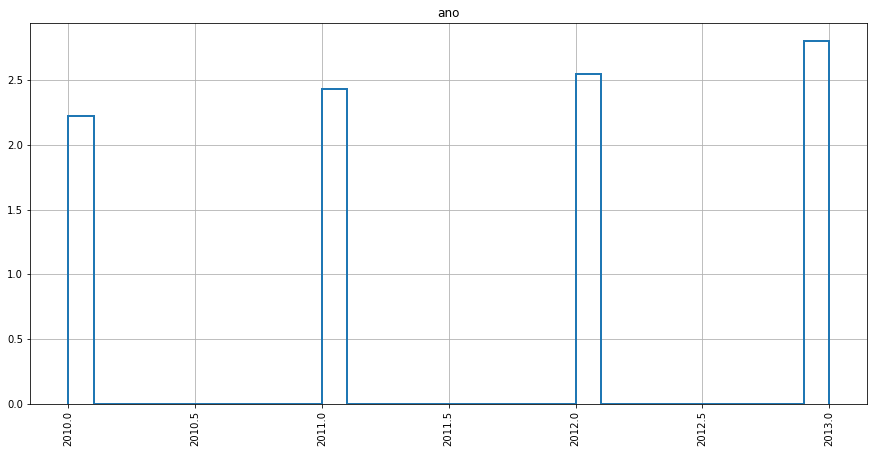

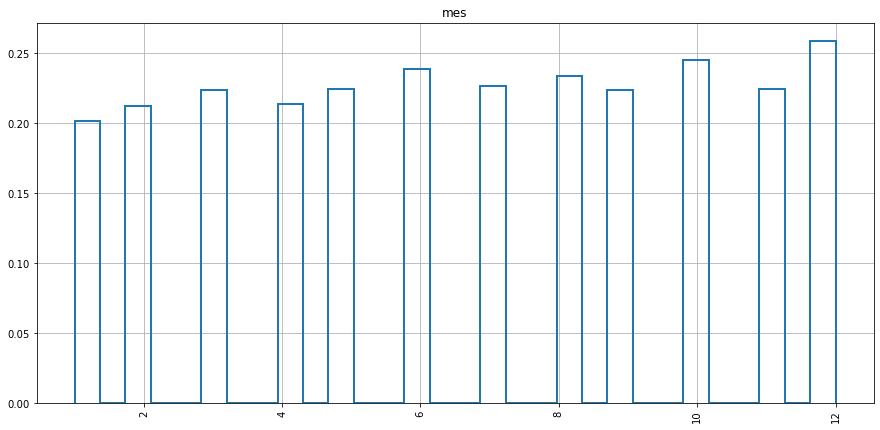

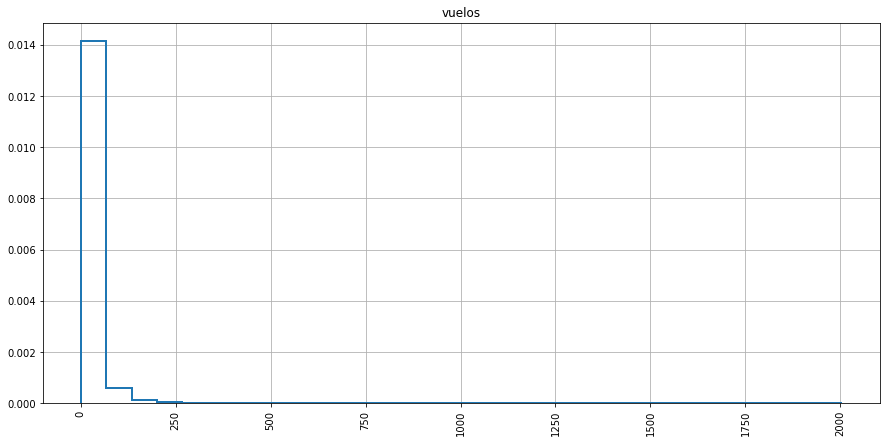

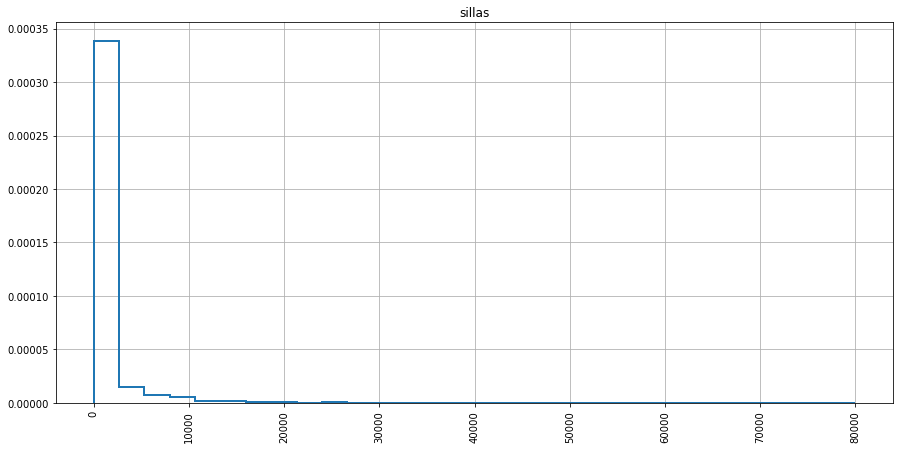

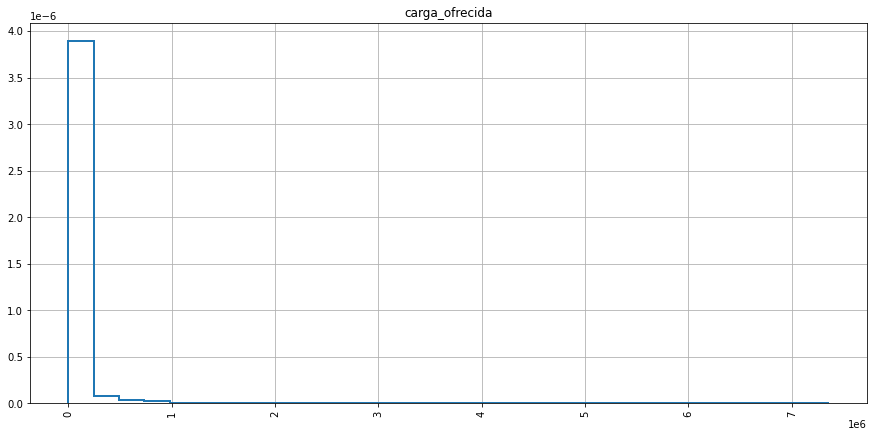

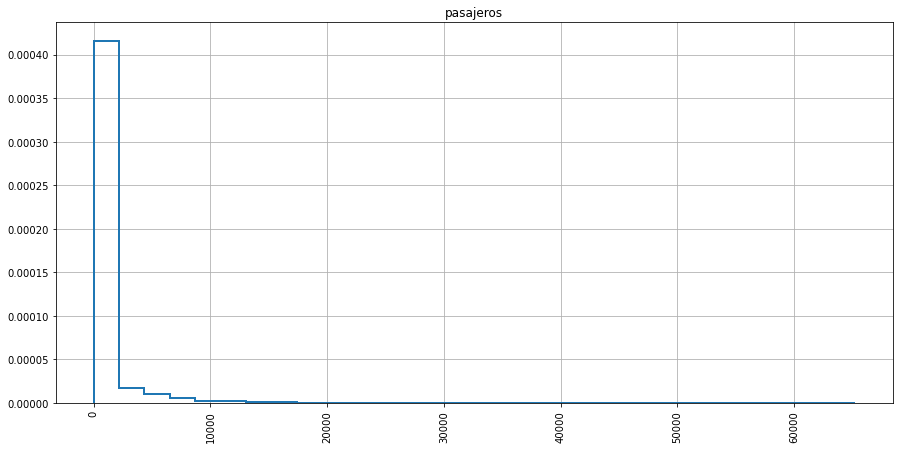

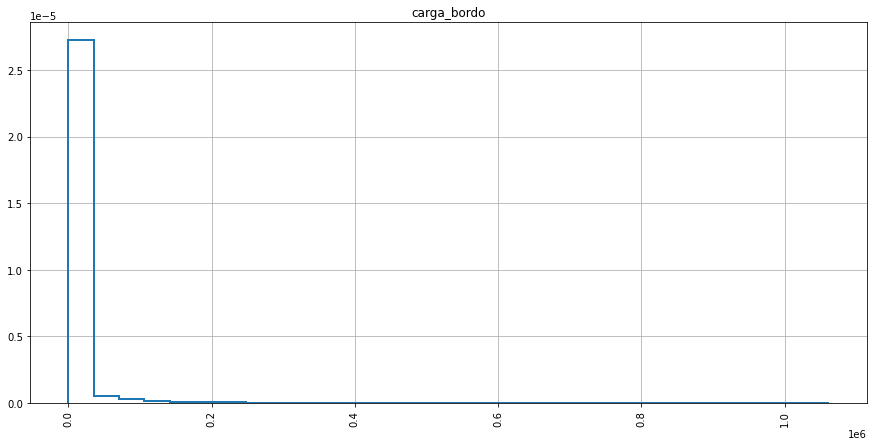

In [41]:

column_names=['ano', 'mes','vuelos', 'sillas', 'carga_ofrecida', 'pasajeros',
       'carga_bordo']
hist_graph(flights, column_names)

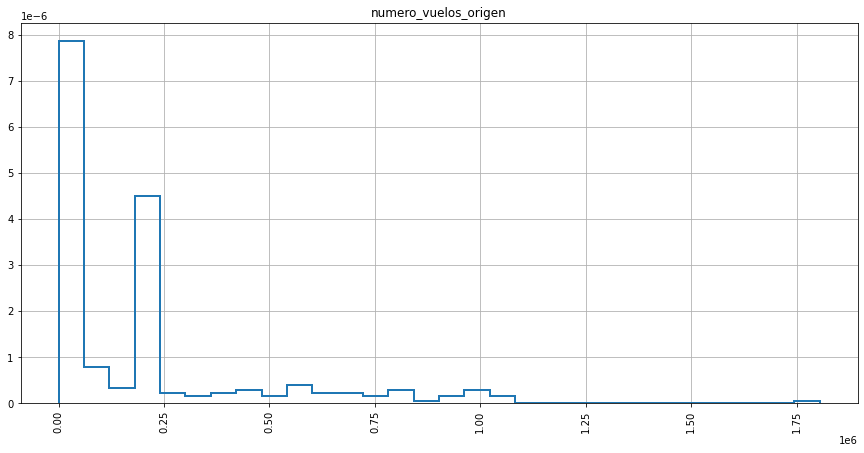

In [42]:
column_names=['numero_vuelos_origen']
hist_graph(airports, column_names)

In [43]:
coverage.columns

Index(['Centro Poblado', 'Aeropuerto', 'Distancia(Km)', 'Cobertura',
       'Aerodromo', 'D_Aerodromo', 'Regional', 'D_Regional', 'Nacional',
       'D_Nacional', 'Internacional', 'D_Internacional', 'Tipo_Cobertura'],
      dtype='object')

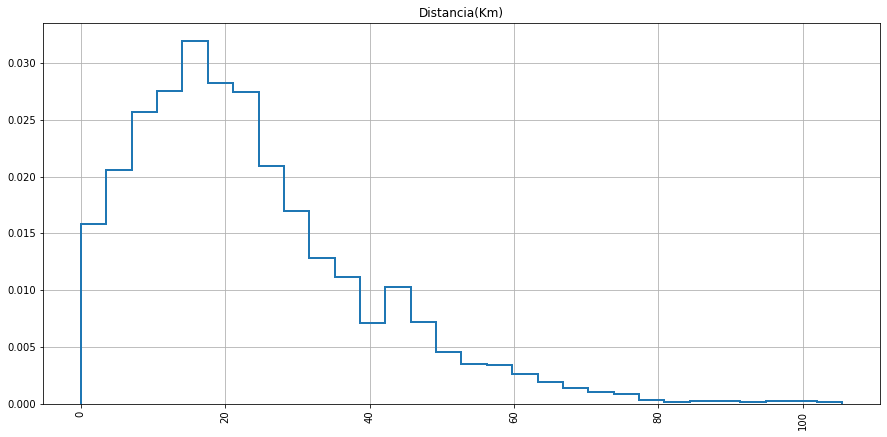

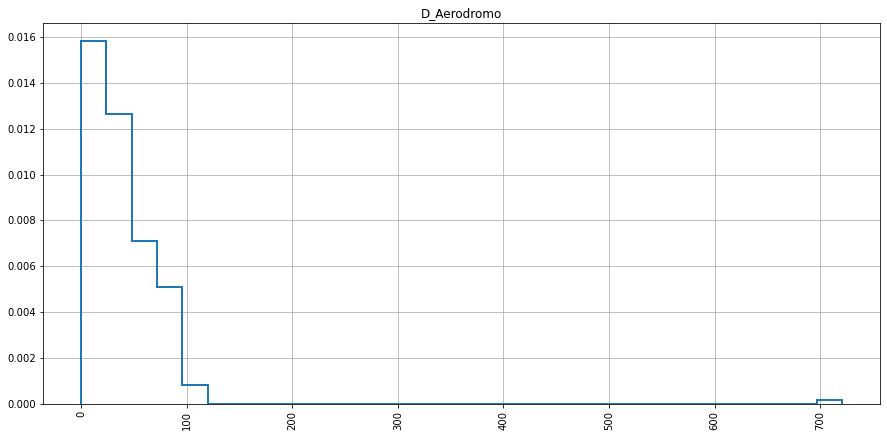

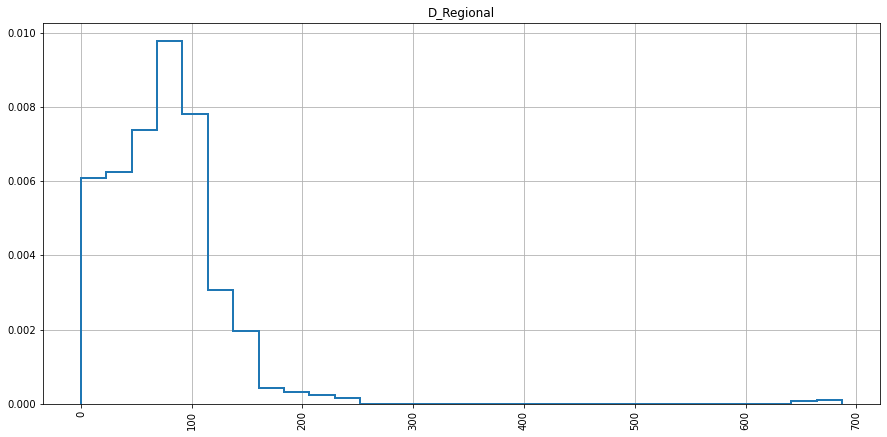

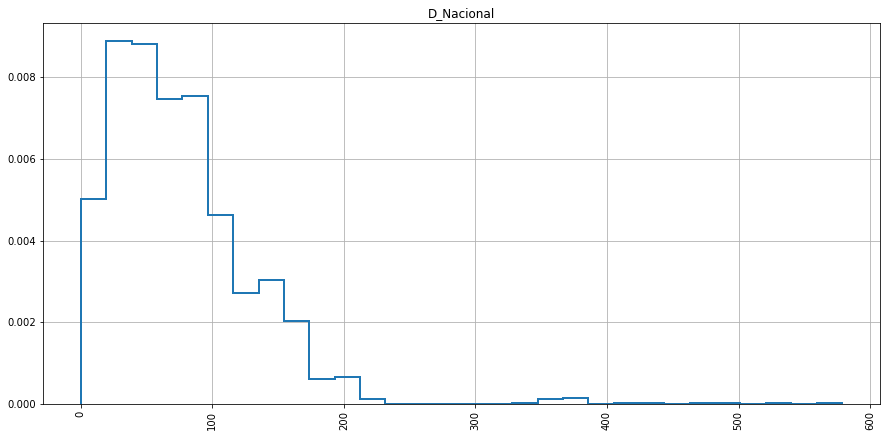

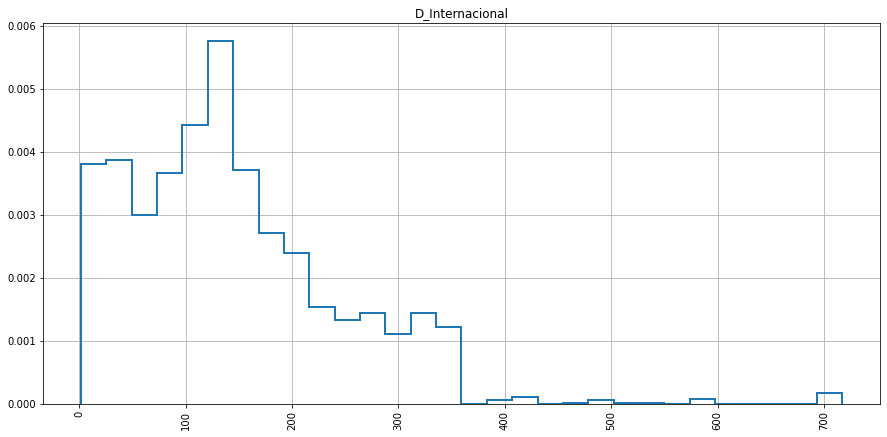

In [44]:
column_names=['Distancia(Km)', 'D_Aerodromo', 'D_Regional', 'D_Nacional', 'D_Internacional']
hist_graph(coverage, column_names)

In [71]:
flights

,ano,mes,origen,destino,tipo_equipo,tipo_vuelo,trafico,empresa,vuelos,sillas,carga_ofrecida,pasajeros,carga_bordo
0,2012,1,BOG,CUC,BE20,T,N,RIO SUR,1.0,0.0,0.0,4.00000,100.00
1,2013,5,UIB,BOG,DH8D,R,N,AIRES,30.0,1110.0,24000.0,873.00000,4222.00
2,2013,10,IBE,BOG,DH8D,R,N,AIRES,98.0,3626.0,56056.0,2866.00000,2323.75
3,2012,4,FLA,BOG,JS32,T,N,SARPA S.A.S,1.0,0.0,0.0,4.00000,0.00
4,2013,7,CUC,AUC,C402,T,N,AEROCHARTER ANDINA S.A.S.,1.0,0.0,0.0,911.72843,180.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67594,2013,3,VVC,NVA,DC3,R,N,ALIANSA,1.0,18.0,1400.0,0.00000,1240.00
67595,2013,9,VVC,NVA,DC3,R,N,ALIANSA,1.0,18.0,2800.0,0.00000,2738.00
67596,2013,9,VVC,PUU,DC3,R,N,ALIANSA,1.0,18.0,1400.0,0.00000,1098.00
67597,2013,1,VVC,RAV,DC3,R,N,ALIANSA,1.0,18.0,1400.0,6.00000,1063.00


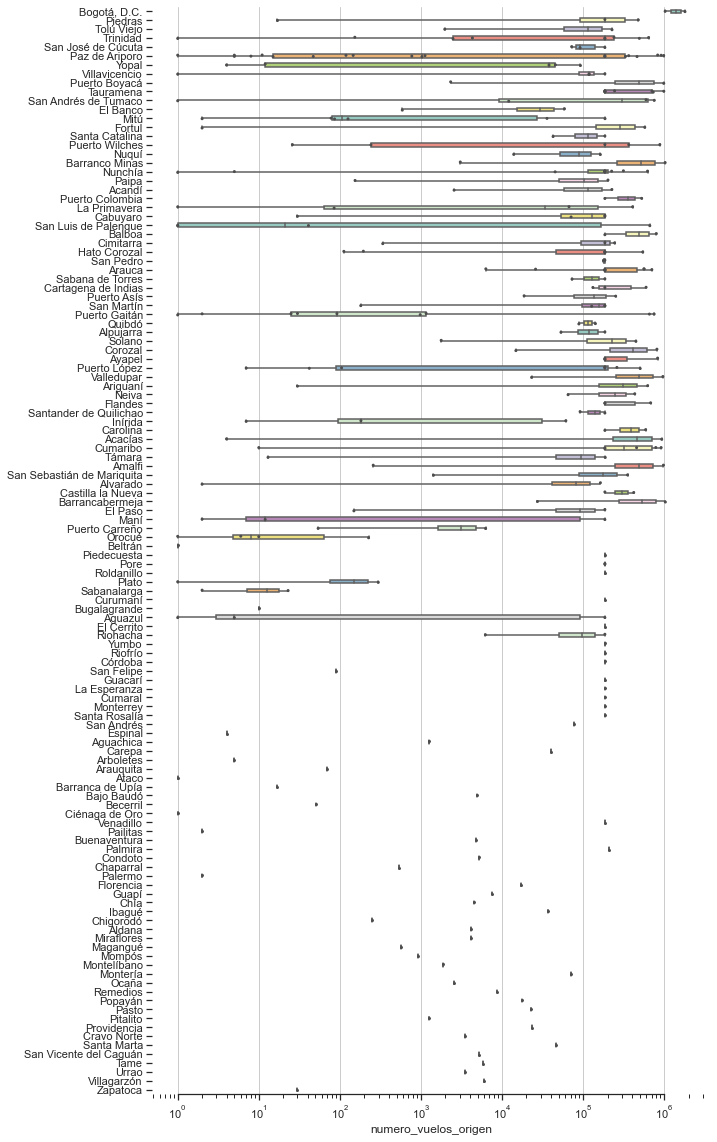

In [70]:
hori_boxplot('numero_vuelos_origen','municipio', airports)

In [113]:
flights_pivot=flights[(flights['ano']>2011) & (flights['ano']<2013)].groupby(['pasajeros','vuelos']).sum()

In [116]:
flights_pivot.describe()

,ano,mes,sillas,carga_ofrecida,carga_bordo
count,3.526000e+03,3526.000000,3526.000000,3.526000e+03,3.526000e+03
mean,9.832323e+03,32.539705,5580.445971,2.361524e+05,2.315760e+04
std,9.734745e+04,330.634185,13011.913290,6.766594e+05,1.342075e+05
min,2.012000e+03,1.000000,0.000000,0.000000e+00,0.000000e+00
25%,2.012000e+03,5.000000,240.000000,2.400000e+03,2.705000e+02
50%,2.012000e+03,9.000000,1396.000000,2.216200e+04,2.199500e+03
75%,4.024000e+03,18.000000,5771.250000,1.411538e+05,1.114000e+04
max,4.074300e+06,13647.000000,222588.000000,1.098549e+07,3.308562e+06


In [117]:
flights.columns

Index(['ano', 'mes', 'origen', 'destino', 'tipo_equipo', 'tipo_vuelo',
       'trafico', 'empresa', 'vuelos', 'sillas', 'carga_ofrecida', 'pasajeros',
       'carga_bordo'],
      dtype='object')

In [118]:
flights[(flights['ano']>2011) & (flights['ano']<2013)].groupby(['origen']).sum()

,ano,mes,vuelos,sillas,carga_ofrecida,pasajeros,carga_bordo
origen,,,,,,,
7FU,4024,22,2.000000,0.000000,0.00,9.000000,130.00
7GC,40240,118,25.000000,0.000000,0.00,1870.456859,318.00
7GD,80480,303,512.000000,0.000000,0.00,6717.728430,56389.14
7GF,146876,488,566.318675,4532.490139,0.00,6887.370578,15687.60
7GH,28168,52,60.527470,3399.367604,0.00,250.000000,3963.60
...,...,...,...,...,...,...,...
UIB,740416,2386,3914.318675,100245.818298,1473285.62,80070.654876,210333.15
VGP,448676,1637,839.263735,31591.960555,504000.00,21867.827438,69010.49
VUP,444652,1507,2839.109881,289674.225347,13336251.46,237334.099008,267324.63


In [119]:
flights[(flights['ano']>2011) & (flights['ano']<2013)].groupby(['carga_bordo']).sum()

,ano,mes,vuelos,sillas,carga_ofrecida,pasajeros
carga_bordo,,,,,,
0.00,8402112,27826,33383.065801,1.255221e+06,12417729.79,923279.660490
1.00,1587468,5690,1116.692291,3.860704e+04,41254.00,40502.594048
1.43,52312,207,40.263735,7.931858e+03,0.00,8231.555867
2.00,219308,799,303.263735,8.664245e+03,143511.00,13563.555867
2.86,6036,27,6.000000,0.000000e+00,0.00,6.000000
...,...,...,...,...,...,...
362628.00,2012,7,10.000000,0.000000e+00,464442.00,0.000000
389199.72,2012,12,14.263735,0.000000e+00,54000.00,911.728430
437728.20,2012,1,6.000000,0.000000e+00,60849.00,0.000000


In [122]:
flights['carga_desperdiciada']=flights['carga_ofrecida'] - flights['carga_bordo']

In [133]:
flights[(flights['ano']>2011) & (flights['ano']<2013)].groupby(['carga_desperdiciada']).sum()

,ano,mes,vuelos,sillas,carga_ofrecida,pasajeros,carga_bordo,puestos_desaprovechados
carga_desperdiciada,,,,,,,,
-376879.20,2012,1,6.000000,0.0,60849.0,0.00000,437728.20,0.00000
-335199.72,2012,12,14.263735,0.0,54000.0,911.72843,389199.72,-911.72843
-244411.16,2012,5,5.000000,0.0,52500.0,0.00000,296911.16,0.00000
-235311.16,2012,1,14.263735,0.0,52500.0,0.00000,287811.16,0.00000
-154792.76,2012,6,94.000000,15792.0,28241.0,10053.00000,183033.76,5739.00000
...,...,...,...,...,...,...,...,...
3872428.00,2012,12,452.000000,67609.0,3949169.0,45385.00000,76741.00,22224.00000
4185535.64,2012,1,14.263735,51907.0,4300281.7,34381.00000,114746.06,17526.00000
4204568.00,2012,6,360.000000,54037.0,4417558.0,47377.00000,212990.00,6660.00000


In [126]:
flights['puestos_desaprovechados']=flights['sillas'] - flights['pasajeros']

In [134]:
flights[(flights['ano']>2011) & (flights['ano']<2013)].groupby(['puestos_desaprovechados']).sum()

,ano,mes,vuelos,sillas,carga_ofrecida,pasajeros,carga_bordo,carga_desperdiciada
puestos_desaprovechados,,,,,,,,
-46708.877465,4024,2,676.00000,2266.245069,1846063.50,95684.000000,313223.20,1532840.30
-43051.877465,2012,2,366.00000,1133.122535,2477963.00,44185.000000,129639.00,2348324.00
-21383.877465,4024,24,316.00000,2266.245069,1659000.00,45034.000000,286527.00,1372473.00
-19764.877465,2012,7,160.00000,1133.122535,55741.00,20898.000000,23760.00,31981.00
-10838.877465,2012,9,88.00000,1133.122535,345657.00,11972.000000,243014.00,102643.00
...,...,...,...,...,...,...,...,...
17526.000000,6036,3,374.52747,155721.000000,10314661.70,103143.000000,275230.06,10039431.64
19490.271570,4024,8,272.00000,40804.000000,1817190.45,1823.456859,44481.15,1772709.30
22224.000000,2012,12,452.00000,67609.000000,3949169.00,45385.000000,76741.00,3872428.00
